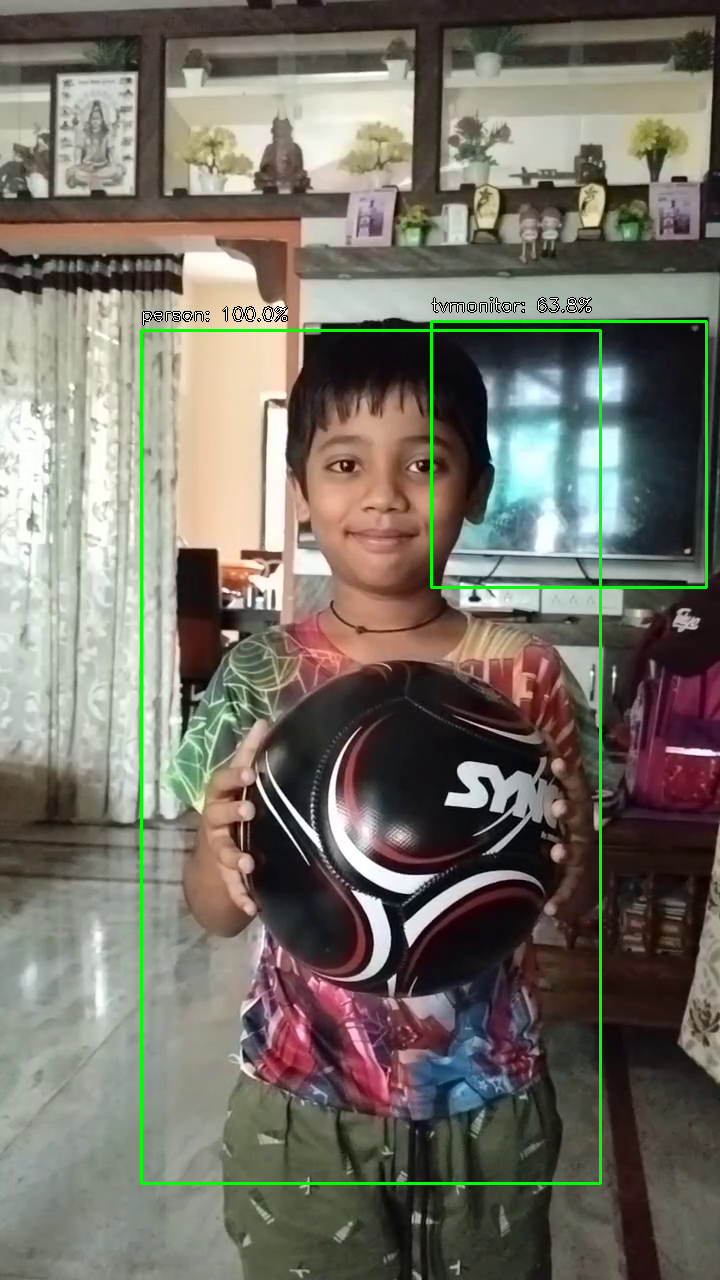

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode

# Load YOLOv3 model
yolo = cv2.dnn.readNetFromDarknet("/content/yolov3.cfg", "/content/yolov3.weights")

# Load class labels
with open("coco.names", "r") as f:
    classes = f.read().strip().splitlines()

# Load input video
cap = cv2.VideoCapture("/content/video3.mp4")

# Video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output video writer
output_path = "/content/output.avi"
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Prepare the blob and set as input to YOLO
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    yolo.setInput(blob)
    output_layers = yolo.getUnconnectedOutLayersNames()
    layer_outputs = yolo.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    # Extract detections
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.6:  # Lowered threshold to detect more objects
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Perform class-wise NMS
    final_indexes = []
    unique_classes = set(class_ids)
    for cls in unique_classes:
        cls_indices = [i for i, cid in enumerate(class_ids) if cid == cls]
        cls_boxes = [boxes[i] for i in cls_indices]
        cls_confidences = [confidences[i] for i in cls_indices]
        nms = cv2.dnn.NMSBoxes(cls_boxes, cls_confidences, 0.5, 0.3)

        for i in nms:
            idx = i[0] if isinstance(i, (list, np.ndarray)) else i
            final_indexes.append(cls_indices[idx])

    # Draw bounding boxes and labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in final_indexes:
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]*100:.1f}%"
        color = (0, 255, 0)  # Green box
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, (x, y - 10), font, 0.6, (0, 0, 0), 2)
        cv2.putText(frame, label, (x, y - 10), font, 0.6, (255, 255, 255), 1)

    # Write frame
    out.write(frame)

    # Show the 10th frame in Colab for preview
    frame_count += 1
    if frame_count == 10:
        cv2_imshow(frame)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

# Convert AVI to MP4 for HTML playback in Colab
mp4_path = "/content/output.mp4"
!ffmpeg -i /content/output.avi -vcodec libx264 -f mp4 "$mp4_path" -y -loglevel quiet

# Display video in Colab
mp4 = open(mp4_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=600 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")
